In [ ]:
# Run this cell to install/update some dependencies in Google Colab
!pip install -U smo scikit-image bottleneck

# Using SMO

## Background-corrected image

While we expect that the main use of SMO will be to background-correct images, there are other possible applications, such as for segmentation, which will be discussed later.

To demonstrate the uses of SMO, we will use the `human_mitosis` sample image from `scikit-image`.

[Text(0.5, 0, 'Intensity'), Text(0, 0.5, 'Counts'), None]

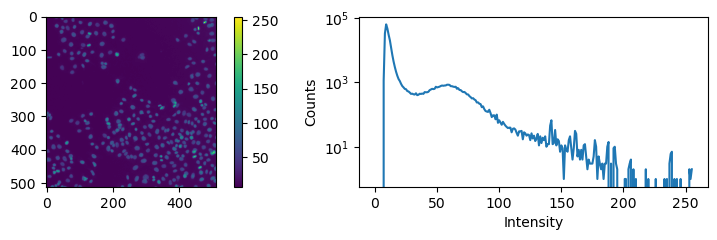

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.data
from smo.api import SMO


plt.rc("figure", dpi=100)  # increase figure resolution

image = skimage.data.human_mitosis()  # load data

fig, ax = plt.subplots(1, 2, figsize=(8, 2.5), tight_layout=True)

# Image
m = ax[0].imshow(image)
plt.colorbar(m, ax=ax[0])

# Histogram
ax[1].plot(np.bincount(image.flat))
ax[1].set(xlabel="Intensity", ylabel="Counts", yscale="log")

To use SMO, we first need to create a SMO instance with our choice of parameters:

In [2]:
smo = SMO(sigma=0, size=7, shape=(1024, 1024))

Then, to background-correct an image, we can do the following:

In [3]:
background_corrected = smo.bg_corrected(image)

To check that the background was properly corrected, we manually selected a background region and compared the histograms of the original and background-corrected images:

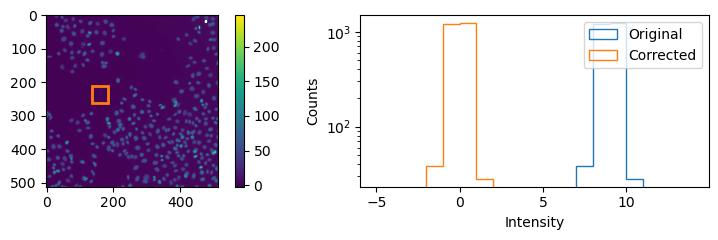

In [4]:
# Manual selection
x0, x1, y0, y1 = 135, 185, 210, 260

fig, ax = plt.subplots(1, 2, figsize=(8, 2.5), tight_layout=True)

# Image
m = ax[0].imshow(background_corrected)
plt.colorbar(m, ax=ax[0])
ax[0].add_patch(
    plt.Rectangle(
        (x0, y0),
        width=x1 - x0,
        height=y1 - y0,
        facecolor="none",
        edgecolor="C1",
        linewidth=2,
    )
)

# Histogram
ax[1].hist(image[y0:y1,x0:x1].flat, bins=np.arange(15), histtype="step", label="Original")
ax[1].hist(background_corrected[y0:y1,x0:x1].compressed(), bins=np.arange(-5, 15), histtype="step", label="Corrected")
ax[1].set(xlabel="Intensity", ylabel="Counts", yscale="log")
ax[1].legend()

The histogram of the background-corrected image is correctly centered around 0.

## SMO in detail

In this section, we will explore the rest of the API methods, to understand how it corrects the background, and what are the other possible uses of SMO.

The API has the following possible outputs:

1. **Background correction**: corrects the image by subtracting the median background intensity (default) or a user-supplied callable to compute an statistic.

2. **Background distribution:** returns a random variable object which can be used to calculate multiple statistics.

3. **Background mask:** in contrast to the background distribution, it still has the spatial location of the sample of background pixels. For instance, if the background is not spatially uniform, it could be used to fit a surface.

4. **Background probability:** it is calculated with the CDF of the background distribution. It could be a useful for segmentation, either as an input to machine learning algorithms or for simpler approaches with thresholding and morphological operators.

4. **SMO probability:** it could be used either for segmentation, or as weights for fitting a background surface when the background is not spatially uniform.

### Importing SMO

The recommended way to use this package is to import `SMO` from `smo.api` and create an instance for some particular choice of parameters:

In [5]:
from smo.api import SMO

smo = SMO(sigma=0, size=7, shape=(1024, 1024))

The `SMO` instance computes the distribution of the null hypothesis (all background pixels). It depends on the choice of parameters (`sigma` and `size`) and is available as an attribute (`SMO.smo_rv`).

### Parameters

SMO has three parameters:

- `sigma`: float. Standard deviation for the Gaussian kernel. It might be useful to smooth the image if the foreground structures are too noisy. Nevertheless, note that the background will be computed for the original non-smoothed image.

- `size`: int. Size of the averaging kernel. It should be smaller than the foreground structures.

- `shape`: tuple[int, ...]. Size of the random image generated to compute the distribution of the null hypothesis. Since we want to apply the algorithm to 2D images, we generated a 1024 x 1024 image.

### Masking the input image

It is important to mask saturated pixels. As there is no local fluctuation of intensity in the saturated areas, it yields a null gradient and the algorithm will confound it with background.

Note that it is not strictly necessary when using `smo.api.SMO`, as a mask will be automatically generated for pixels equal to the maximum intensity when the input is not a `numpy.ma.MaskedArray`.

In [6]:
masked_image = np.ma.masked_greater_equal(image, 255)  # image is uint8 (0-255)

### SMO image and SMO probability image

The SMO image (left) gives a value between 0 and 1 which measures the local correlation in gradient direction.

On the right, it is rescaled with the distribution of the null hypothesis (by applying `smo.smo_rv.cdf`), giving the probability that each pixel doesn't correspond to background.

This last image might be useful as an input to machine learning algorithms for segmentation, or if the underlying background is not spatially uniform.

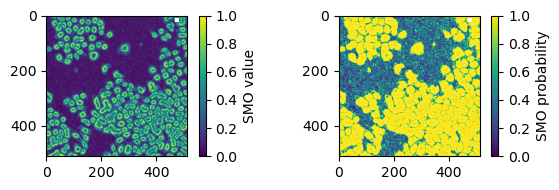

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(6, 2), tight_layout=True)

m = ax[0].imshow(smo.smo_image(masked_image), vmin=0, vmax=1)
plt.colorbar(m, ax=ax[0], label="SMO value")

m = ax[1].imshow(smo.smo_probability(masked_image), vmin=0, vmax=1)
plt.colorbar(m, ax=ax[1], label="SMO probability")

## Background mask

The `SMO.bg_mask` method returns the original image with a mask corresponding to the pixels that were deemed to be background. That mask is calculated by applying a `threshold` to the SMO probability image. By default, the `threshold` is set on 0.05.

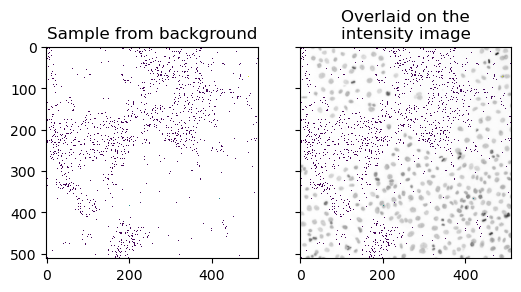

In [8]:
bg_mask = smo.bg_mask(image, threshold=0.05)

fig, ax = plt.subplots(1, 2, sharey=True)

ax[0].set(title="Sample from background")
ax[0].imshow(bg_mask, interpolation="none")

ax[1].set(title="Overlaid on the\nintensity image")
ax[1].imshow(image, cmap="gray_r")
ax[1].imshow(bg_mask, interpolation="none")

It is recommended to use a small threshold, that excludes as much foreground as possible.

### Background-corrected image

The background-corrected image we used before simply takes `bg_mask` and computes a single value, which by default is `np.median` and subtracts it from the original image.

In [9]:
bg_value = np.median(bg_mask.compressed())
bg_value

9.0

In [10]:
(smo.bg_corrected(image) == image - bg_value).all()

True

### Background distribution

Another possibility is to calculate the background distribution with the `SMO.bg_rv` method, which returns a `scipy.stats.continuous_rv` distribution.

In [11]:
bg_rv = smo.bg_rv(image)

bg_rv

With it, we can compute any desired statistic. For instance, the first and third quartiles:

In [12]:
bg_rv.ppf((0.25, 0.75))

array([7.97924512, 9.8775481 ])

## Background probability

Finally, we could rescale the intensity image with the background distribution CDF (cumulative density function) to obtain an image where the value of each pixel corresponds to the probability of not belonging to the background.

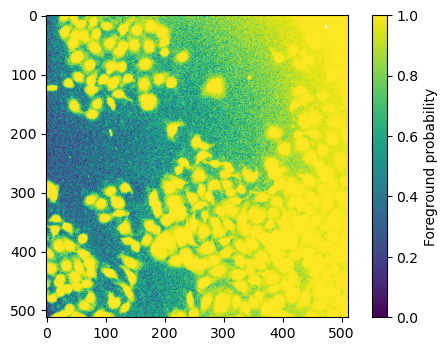

In [13]:
bg_prob = smo.bg_probability(image)

plt.imshow(bg_prob)
plt.colorbar(label="Foreground probability")

This image could be useful for segmentation, either as an input for machine learning algorithms, or for a simpler procedure with morphological operators.

Nevertheless, while all cells have probabilities near 1, a slight gradient can be seen in the background region. It can also be seen in the original image if we restrict the color scale to the range of background values, or looking at line profiles of intensity:

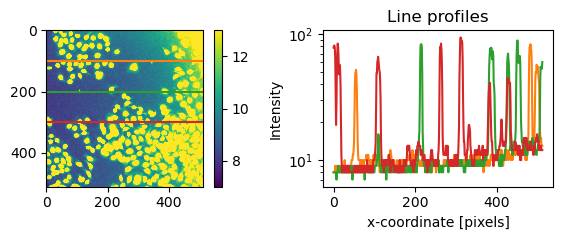

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(6, 2.5), tight_layout=True)

m = ax[0].imshow(image, vmax=13)
plt.colorbar(m, ax=ax[0])

ax[1].set(
    yscale="log",
    title="Line profiles",
    xlabel="x-coordinate [pixels]",
    ylabel="Intensity",
)

for color, line in zip(["C1", "C2", "C3"], [100, 200, 300]):
    ax[0].axhline(line, color=color)
    ax[1].plot(image[line], color=color)

In this case, we could try to estimate a background surface using the output of `smo.bg_mask`:

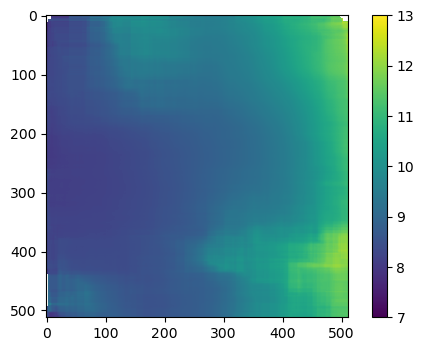

In [15]:
import bottleneck

bg_mask = smo.bg_mask(image, threshold=0.1)

# Local mean on a 100x100 window
bg_surface = np.ma.masked_greater(bg_mask.astype(float), 20).filled(np.nan)
for axis in range(2):
    bg_surface = bottleneck.move_mean(bg_surface, window=100, min_count=1, axis=axis)
    
plt.imshow(bg_surface)
plt.colorbar()

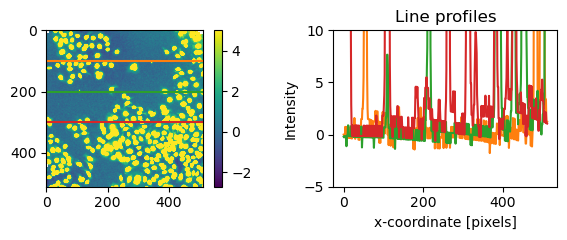

In [16]:
bg_corrected = image - bg_surface

fig, ax = plt.subplots(1, 2, figsize=(6, 2.5), tight_layout=True)

m = ax[0].imshow(bg_corrected, vmax=5)
plt.colorbar(m, ax=ax[0])

ax[1].set(
    ylim=(-5, 10),
    title="Line profiles",
    xlabel="x-coordinate [pixels]",
    ylabel="Intensity",
)

for color, line in zip(["C1", "C2", "C3"], [100, 200, 300]):
    ax[0].axhline(line, color=color)
    ax[1].plot(bg_corrected[line], color=color)